In [1]:
#import processing
import ds
#import ml
import model_saving
import TS
import TA
# Load the necessary packages and modules
#from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import pandas as pd
import numpy
import numpy as np
import math as m
import talib
import pickle
from sklearn import svm

from hmmlearn.hmm import GaussianHMM
from sklearn.externals import joblib

/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


In [2]:
filename='/home/octo/Dropbox'+ '/SPY19.csv'

In [3]:
# Import a Kalman filter and other useful libraries
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import poly1d

def kalman_ma(data):
    x=data.Close
    # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = x[1],
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    #df_ml['km']=state_means
    return state_means

In [6]:
# loading csv file
def get_csv_pd(path):
    spy_pd=pd.read_csv(path,sep=',',dtype={'askPrice':np.float32,'askSize':np.float32,
                                           'bidPrice':np.float32,'bidSize':np.float32},index_col=0,parse_dates=True)
    return spy_pd
def processing(df):
    df=df.drop(['Stock'], axis=1)
    df['Open']=((df.askPrice+df.bidPrice)/2)
    df['ABSR']=df.askSize/df.bidSize
    df['ABST']=(df.askSize+df.bidSize)
    #df['ABP']=df.Open-df.Open.rolling(6).mean()
    df.Volume=df.Volume.diff(6) 
    df['vwap']=((df.loc[:,'bidPrice']*df.loc[:,'bidSize'])+(df.loc[:,'askPrice']*df.loc[:,'askSize']))/(df.loc[:,'bidSize']+df.loc[:,'askSize'])
    df['OC']=df.Open-df.Close
    df['HL']=df.High-df.Low #if positive then market positive rather market negative
    df.Close=df.lastprice
    df['km']=df.Open-kalman_ma(df)
    df['UD']=np.where(np.logical_and(df.Open.diff(6)>0.005,df.km>0),1,np.where(np.logical_and(df.Open.diff(6)<-0.005,df.km<0),-1,0))
    df['U']=np.where(np.logical_and(df.Open.diff(6)>0.005,df.km>0),1,0)
    df['D']=np.where(np.logical_and(df.Open.diff(6)<-0.005,df.km<0),-1,0)
    #df=df.drop(['askSize','bidSize','lastprice','askPrice','bidPrice','km'], axis=1)
    #df.ABD=df.ABD.diff(1)
    #df.OC=df.OC.diff(1)
    #df.HL=df.HL.diff(1)
    df.ABST=df.ABST/df.ABST.rolling(6).mean()
    df.vwap=df.vwap-df.Open.rolling(6).mean() 
    return df

def tech_ind(data):
    data['rsi']=talib.RSI(np.array(data.Close.astype('float64')),timeperiod=6)
    data.rsi=data.rsi/100
    data['atr']=talib.ATR(np.array(data.High.astype('float64')),np.array(data.Low.astype('float64')),np.array(data.Close.astype  ('float64')),timeperiod=6)
    data['mom']=talib.MOM(np.array(data.Close.astype('float64')), timeperiod=6)# mom consists 0
    #data.atr=data.atr-data.atr.rolling(6).mean()
    #data.mom=data.mom-data.mom.rolling(6).mean()
    #data=data.drop(['Open','High','Close','Low'], axis=1)
    return data

In [7]:
data=get_csv_pd(filename)
data=processing(data)
data=tech_ind(data)
data=data[500:]

In [8]:
data=data.astype('float64')
data=data.dropna()

In [9]:
data.head()

,Close,High,Low,Volume,askPrice,askSize,bidPrice,bidSize,...,HL,km,UD,U,D,rsi,atr,mom
2018-04-19 19:12:39.267220,269.40000,269.81000,269.05000,0.00000,269.42001,7.00000,269.39999,105.00000,...,0.76000,0.00708,0.00000,0.00000,0.00000,0.22328,0.76000,0.00000
2018-04-19 19:12:39.269495,269.40000,269.81000,269.05000,0.00000,269.41000,7.00000,269.39999,105.00000,...,0.76000,0.00235,0.00000,0.00000,0.00000,0.22328,0.76000,0.00000
2018-04-19 19:12:39.271532,269.40000,269.81000,269.05000,0.00000,269.41000,3.00000,269.39999,105.00000,...,0.76000,0.00261,0.00000,0.00000,0.00000,0.22328,0.76000,0.00000
2018-04-19 19:12:39.273635,269.40000,269.81000,269.05000,0.00000,269.41000,3.00000,269.39999,105.00000,...,0.76000,0.00283,0.00000,0.00000,0.00000,0.22328,0.76000,0.00000
2018-04-19 19:12:39.275695,269.40000,269.81000,269.05000,0.00000,269.41000,3.00000,269.39999,105.00000,...,0.76000,0.00304,0.00000,0.00000,0.00000,0.22328,0.76000,0.00000


In [15]:
np.corrcoef(data.UD,data.ABSR)

array([[1.     , 0.19067],
       [0.19067, 1.     ]])

In [16]:
print(data.groupby('UD').size())

UD
-1.00000     6465
0.00000     14816
1.00000      6012
dtype: int64


## State Analysis

In [24]:
from hmmlearn.hmm import GaussianHMM
print("fitting to HMM and decoding ...", end="")
# Make an HMM instance and execute fit
model_hmm = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000)
#model_hmm.fit(data[['Volume','vwap','km','rsi', 'atr','mom']])
model_hmm.fit(data[['Volume','ABSR','ABST','vwap','OC','HL']])

fitting to HMM and decoding ...

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=3, n_iter=1000, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

In [25]:
from sklearn.externals import joblib
joblib.dump(model_hmm, "markov_hmm.pkl")

['markov_hmm.pkl']

In [27]:
X=data[['Volume','ABSR','ABST','vwap','OC','HL','rsi','atr','mom']]
Y=data.UD

## SMOTE

In [26]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

In [28]:
sm = SMOTE(random_state=14, ratio ='minority')
X_o,Y_o = sm.fit_sample(X,Y)

## BAYES

In [29]:
import numpy as np
import sklearn
from sklearn.naive_bayes import BernoulliNB
#from sklearn.naive_bayes import GaussianNB

In [30]:
X=data[['Volume','ABSR','ABST','vwap','OC','HL','rsi','atr','mom']]
Yu=data.U
Yd=data.D

#### UP

In [31]:
sm = SMOTE(random_state=14, ratio ='minority')
X_o,Y_o = sm.fit_sample(X,Yu)

In [32]:
bnb = BernoulliNB()
bnb.fit(X_o, Y_o)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [33]:
filename_nb = 'nbU.sav'
pickle.dump(bnb, open(filename_nb, 'wb'))

#### DN

In [34]:
sm = SMOTE(random_state=15, ratio ='minority')
X_o,Y_o = sm.fit_sample(X,Yd)

In [35]:
bnb = BernoulliNB()
bnb.fit(X_o, Y_o)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [36]:
filename_nb = 'nbD.sav'
pickle.dump(bnb, open(filename_nb, 'wb'))

## outlier

In [37]:
#outlier = svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
outlier = svm.OneClassSVM(kernel="poly", degree=3, gamma="auto", coef0=4.0, tol=0.001, nu=0.05, shrinking=True, cache_size=200, verbose=False, max_iter=-1, random_state=None)
outlier.fit(data[['Volume','ABSR','ABST','vwap','OC','HL','rsi','atr','mom']])

OneClassSVM(cache_size=200, coef0=4.0, degree=3, gamma='auto', kernel='poly',
      max_iter=-1, nu=0.05, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [38]:
filename_outlr = 'outlr.sav'
pickle.dump(outlier, open(filename_outlr, 'wb'))

## RF for UD

In [39]:
sm = SMOTE(random_state=11, ratio ='minority')
X_o,Y_o = sm.fit_sample(X,Y)

In [40]:
SEED=15
rf = RandomForestClassifier(
    n_estimators=9,
    max_features=6,
    random_state=SEED
)

rf.fit(X_o,Y_o)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=1,
            oob_score=False, random_state=15, verbose=0, warm_start=False)

In [41]:
filename_rf = 'rf.sav'
pickle.dump(rf, open(filename_rf, 'wb'))

## Analysis
Not for modeling

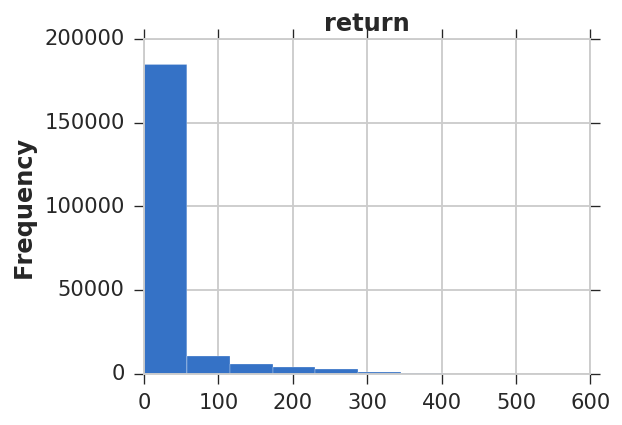

In [12]:
import matplotlib.pyplot as plt
data['ABSR'].plot(kind='hist', grid=True, title='return')
plt.show()

In [13]:
data_a=data

In [24]:
data_a['as']=np.where(data_a.askSize>50,1,0)

In [25]:
print(data.groupby('as').size())

as
0    130960
1     77695
dtype: int64


In [26]:
data_a['bs']=np.where(data_a.bidSize>50,1,0)

In [27]:
print(data.groupby('bs').size())

bs
0    144241
1     64414
dtype: int64


In [28]:
pd.crosstab(index=data.UD,columns=data.bs)

bs,0,1
UD,,
-1.00000,20948,33515
0.00000,74843,25309
1.00000,48450,5590


In [29]:
pd.crosstab(index=data.UD,columns=data['as'])

as,0,1
UD,,
-1.00000,44714,9749
0.00000,65271,34881
1.00000,20975,33065


# bidsize>50 for down and asksize>50 for up